In [51]:
import sys
import numpy as np
import pandas as pd
from scipy.misc import imread
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

import tensorflow as tf

import keras2onnx
import onnx

### Please give below paths as per the paths in your system

In [52]:
train_folder = "../katzen_training/"
val_folder = '../katzen_validierung/'
save_path = '../data/'

In [53]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path, mode='I')
                # image = imread(image_path, mode='L')
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

### Loading the train images into tensors

In [54]:
X,y,c=loadimgs(train_folder)

loading alphabet: 01_katzen


/home/osboxes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


### Saving the train tensors on disk

In [55]:
with open(os.path.join(save_path,"train.pickle"), "wb") as f:
    pickle.dump((X,c),f)

### Loading the validation images into tensors

In [56]:
Xval,yval,cval=loadimgs(val_folder)

loading alphabet: 02_katzen


/home/osboxes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


### Saving the validation tensors on disk

In [57]:
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
    pickle.dump((Xval,cval),f)

In [58]:
# del X, y ,c ,Xval, yval, cval

In [59]:
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [60]:
def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [61]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [62]:
model = get_siamese_model((128, 128, 1))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 4096)         68307776    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 4096)         0           sequential_4[1][0]               
          

In [63]:
from IPython.display import Image
# Image(retina=True, filename='model.png')

In [64]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

### Loading the train tensors

In [65]:
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(train_classes.keys()))

Training alphabets: 

['01_katzen']


In [66]:
with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)

print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Validation alphabets:

['02_katzen']


In [67]:
def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    
    n_classes, n_examples, w, h = X.shape

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets

In [68]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [69]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [70]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [71]:
# Hyper parameters
evaluate_every = 10 # interval for evaluating on one-shot tasks
batch_size = 5
n_iter = 100 # No. of training iterations
N_way = 2 # how many classes for testing one-shot tasks
n_val = 20 # how many one-shot tasks to validate on
best = -1

In [72]:
model_path = '../01_weights/'
frozen_path = '../01_frozen'
onnx_path = '../01_onnx'
inference_path = '../01_inference'

In [73]:
# Inference Model
lmodel = get_siamese_model((128, 128, 1))

In [36]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        ## Store as tensorflow graph
        lmodel.load_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        lmodel.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
        sess = K.get_session()
        outname = "output_node0"
        tf.identity(lmodel.outputs[0],name=outname)
        constant_graph = tf.graph_util.convert_variables_to_constants(sess,sess.graph.as_graph_def(),[outname])
        tf.train.write_graph(constant_graph, './', os.path.join(frozen_path, 'frozen.{}.pb'.format(i)), as_text=False)
        ##
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------

 ------------- 

Time for 10 iterations: 0.7224379062652588 mins
Train Loss: 6.1307172775268555
Evaluating model on 20 random 2 way one-shot learning tasks ... 

Got an average of 80.0% 2 way one-shot learning accuracy 

INFO:tensorflow:Froze 12 variables.
INFO:tensorflow:Converted 12 variables to const ops.
Current best: 80.0, previous best: -1

 ------------- 

Time for 20 iterations: 1.438726019859314 mins
Train Loss: 5.8802080154418945
Evaluating model on 20 random 2 way one-shot learning tasks ... 

Got an average of 95.0% 2 way one-shot learning accuracy 

INFO:tensorflow:Froze 12 variables.
INFO:tensorflow:Converted 12 variables to const ops.
Current best: 95.0, previous best: 80.0

 ------------- 

Time for 30 iterations: 2.100868988037109 mins
Train Loss: 5.624120235443115
Evaluating model on 20 random 2 way one-shot learning tasks ... 

Got an average of 95.0% 2 way one-shot learning accuracy 

INFO:tensorflow:

## Some Visualization Functions

In [74]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [75]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(128,128), cmap='CMRmap')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='CMRmap')
    plt.xticks([])
    plt.yticks([])
    plt.show()

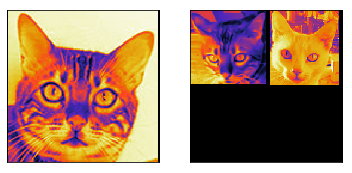

[[0.5992119 ]
 [0.40091234]]
[1. 0.]


In [92]:
model.load_weights(os.path.join(model_path, "weights.60.h5"))
pairs, targets = make_oneshot_task(2,"test","02_katzen")
plot_oneshot_task(pairs)
print(model.predict(pairs))
print(targets)

### Testing

### Baseline model based on Nearest Neighbors using Euclidean distance (L2 distance)

In [93]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [94]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [97]:
ways = np.arange(1,3,1)
resume =  False
trials = 50

In [98]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("---------------------------------------------------------------------------------------------------------------")

Evaluating model on 50 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 50 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 1 way one-shot learning tasks ...
NN Accuracy =  100.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 2 way one-shot learning tasks ... 



/home/osboxes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


Got an average of 88.0% 2 way one-shot learning accuracy 

Evaluating model on 50 random 2 way one-shot learning tasks ... 

Got an average of 74.0% 2 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 2 way one-shot learning tasks ...
NN Accuracy =  50.0
---------------------------------------------------------------------------------------------------------------


### Save the accuracies on disk

In [99]:
with open(os.path.join(save_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)

### Load the accuracies from disk

In [100]:
with open(os.path.join(save_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

### Resuts

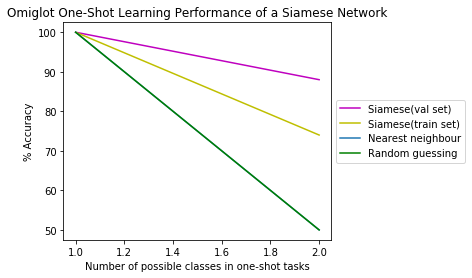

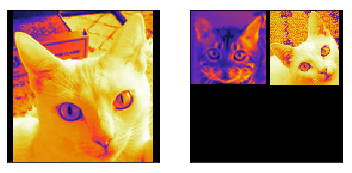

In [105]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = make_oneshot_task(2, "val", '02_katzen')
plt.show()

plot_oneshot_task(inputs)